## Colab Setup

In [1]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.3.0 spark-nlp==4.2.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.8/453.8 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 20.6 MB/s eta 0:00:00


## Importing Necessary libraries

In [2]:
from pyspark.sql import functions as F
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.pretrained import *

## Start Spark Session

In [3]:
spark = sparknlp.start()

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 4.2.8
Apache Spark version: 3.3.0


## Loading Emotions Data

In [4]:
# Your existing code
emo6 = ['anger', 'fear', 'joy', 'sadness', 'suprise', 'neutral']
data = spark.read.option('header', True)\
    .csv('/content/drive/MyDrive/emotion_dataset_raw.csv')\
    .where(F.col('Emotion').isin(emo6))

print('Total instances (sample): {:,}'.format(data.count()))

Total instances (sample): 29,728


## Data Visualization

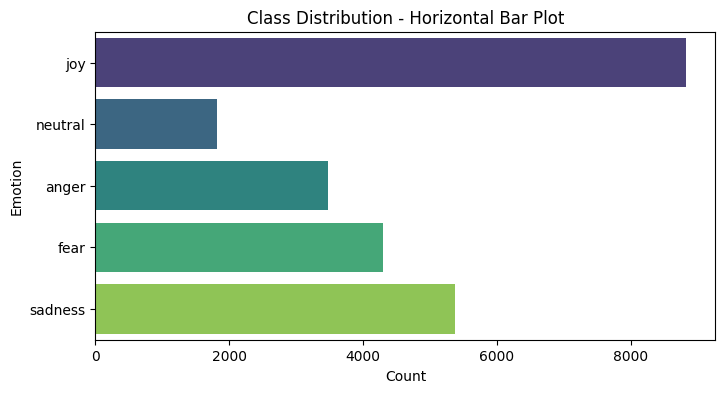

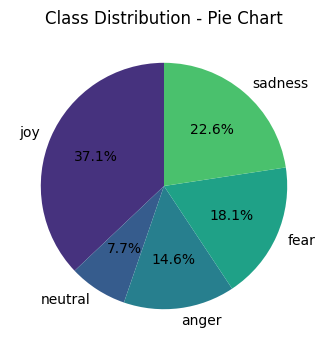

In [5]:
(train_data,test_data) = data.randomSplit([0.8, 0.2], seed = 1234)

def plot_class_distribution(df):
    emotion_column = 'Emotion'

    # Calculate class counts
    class_counts = train_data.groupBy(emotion_column).count().toPandas()

    # Plot horizontal bar chart
    plt.figure(figsize=(8, 4))
    sns.barplot(x='count', y=emotion_column, data=class_counts, palette='viridis')
    plt.title('Class Distribution - Horizontal Bar Plot')
    plt.xlabel('Count')
    plt.ylabel('Emotion')
    plt.show()

    # Plot pie chart
    plt.figure(figsize=(4, 4))
    plt.pie(class_counts['count'], labels=class_counts[emotion_column], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis'))
    plt.title('Class Distribution - Pie Chart')
    plt.show()

plot_class_distribution(train_data)

## Balancing the dataset

In [6]:
# Calculate the count of each class
class_counts = data.groupBy('Emotion').count()

# Find the minimum count (minority class)
min_count = class_counts.agg({"count": "min"}).collect()[0][0]

# Undersample the majority class based on the minimum count
undersampled_data = data.withColumn(
    "row_number",
    F.row_number().over(Window.partitionBy("Emotion").orderBy(F.monotonically_increasing_id()))
).filter(F.col("row_number") <= min_count).drop("row_number")

print('Total instances (undersampled): {:,}'.format(undersampled_data.count()))

(train_data_bal,test_data_bal) = undersampled_data.randomSplit([0.8, 0.2],seed=1234)

Total instances (undersampled): 11,270


## Balanced Training Dataset



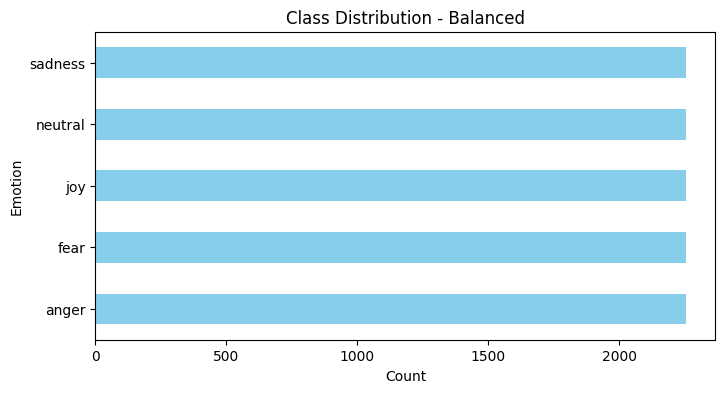

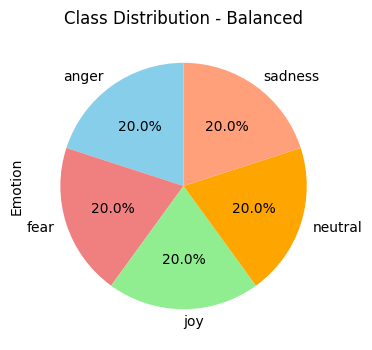

In [7]:
# Convert PySpark DataFrame to Pandas DataFrame for visualization
pandas_data = undersampled_data.toPandas()

# Plot a horizontal bar chart
plt.figure(figsize=(8, 4))
pandas_data['Emotion'].value_counts().plot(kind='barh', color='skyblue')
plt.title('Class Distribution - Balanced')
plt.xlabel('Count')
plt.ylabel('Emotion')
plt.show()

# Plot a pie chart
plt.figure(figsize=(4, 4))
pandas_data['Emotion'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen', 'orange', 'lightsalmon', 'lightgray'])
plt.title('Class Distribution - Balanced')
plt.show()

## Text Pre-Processing (TPP) Pipeline Implementation

In [8]:
document_assembler= DocumentAssembler()\
    .setInputCol('Text')\
    .setOutputCol('document')

sentence_detector = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentences')

tokenizer = Tokenizer()\
    .setInputCols(['sentences'])\
    .setOutputCol('tokens')

spell_checker = NorvigSweetingModel.pretrained()\
    .setInputCols('tokens')\
    .setOutputCol('tokens_spl')

normalizer = Normalizer()\
    .setInputCols(['tokens_spl'])\
    .setOutputCol('tokens_nf')\
    .setLowercase(True)

stop_words_cleaner = StopWordsCleaner()\
    .setInputCols(['tokens_nf'])\
    .setOutputCol('tokens_nosw')\
    .setCaseSensitive(False)

lemmatizer = LemmatizerModel.pretrained()\
    .setInputCols(['tokens_nosw'])\
    .setOutputCol('tokens_nosw_lf')

pipeline_tpp = Pipeline(
    stages = [
        document_assembler,
        sentence_detector,
        tokenizer,
        spell_checker,
        normalizer,
        stop_words_cleaner,
        lemmatizer
    ]
)

spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


## Execute TPP Pipeline

In [9]:
import pyspark.sql.types as T
udf_tokens_to_string = F.udf((lambda zlist: ' '.join(zlist)), T.StringType())

pipeline_tpp_model_bal = pipeline_tpp.fit(train_data_bal)
train_data_bal_tpp = pipeline_tpp_model_bal.transform(train_data_bal)\
  .withColumnRenamed('Processed Text', 'Text')\
  .withColumn('Processed Text', udf_tokens_to_string(F.col('tokens_nosw_lf.result')))
test_data_bal_tpp = pipeline_tpp_model_bal.transform(test_data_bal)\
  .withColumnRenamed('Processed Text', 'Text')\
  .withColumn('Processed Text', udf_tokens_to_string(F.col('tokens_nosw_lf.result')))

train_data_bal_tpp.limit(5).show()

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Emotion|                Text|            document|           sentences|              tokens|          tokens_spl|           tokens_nf|         tokens_nosw|      tokens_nosw_lf|      Processed Text|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  anger|   #SAD #LONELY a...|[{document, 0, 73...|[{document, 3, 60...|[{token, 3, 6, #S...|[{token, 3, 6, #S...|[{token, 3, 5, sa...|[{token, 3, 5, sa...|[{token, 3, 5, sa...|sad lonely find p...|
|  anger| &quot;If you are...|[{document, 0, 98...|[{document, 1, 6,...|[{token, 1, 5, &q...|[{token, 1, 5, qu...|[{token, 1, 4, qu...|[{token, 1, 4, qu...|[{token, 1, 4, qu...|quot patient one ...|
|  an

## Multi-Class Text Classification using Classifier DL

In [11]:
# Sentence Embeddings with USE
senetence_embeddings_use = UniversalSentenceEncoder.pretrained(name='tfhub_use',lang='en')\
    .setInputCols(['document'])\
    .setOutputCol('sentence_embeddings')

classifier_dl = ClassifierDLApproach()\
    .setInputCols(['sentence_embeddings'])\
    .setLabelColumn('Emotion')\
    .setOutputCol('class')\
    .setMaxEpochs(30)


pipeline_use = Pipeline(
    stages=[
        document_assembler,
        senetence_embeddings_use,
        classifier_dl
    ]
)

model = pipeline_use.fit(train_data_bal_tpp)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


## Infering Emotions with a model

In [14]:
predictions = model.transform(test_data_bal)
predictions.select('Text', 'Emotion', 'class.result', 'class.metadata').show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+---------+-----------------------------------------------------------------------------------------------------------------------------------+
|Text                                                                                                                                                                                    |Emotion|result   |metadata                                                                                                                           |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+---------+--------------------------------------------------------------------------------------------------------------------------

## Evaluating model with Classification Report

In [15]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Extracting true labels and predicted labels
true_labels = predictions.select('Emotion').rdd.flatMap(lambda x: x).collect()
predicted_labels = predictions.select('class.result').rdd.flatMap(lambda x: x).collect()

# Encode the labels using sklearn's LabelEncoder
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(true_labels)
predicted_labels_encoded = label_encoder.transform(predicted_labels)

# Calculate and display the classification report
report = classification_report(true_labels_encoded, predicted_labels_encoded, target_names=label_encoder.classes_)
print(report)

              precision    recall  f1-score   support

       anger       0.60      0.66      0.63       436
        fear       0.68      0.59      0.63       428
         joy       0.66      0.67      0.67       450
     neutral       0.80      0.85      0.83       463
     sadness       0.60      0.57      0.58       471

    accuracy                           0.67      2248
   macro avg       0.67      0.67      0.67      2248
weighted avg       0.67      0.67      0.67      2248



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


## Saving the model and pipeline

In [16]:
model.save("/content/drive/MyDrive/model")